In [3]:
import fastf1 as ff1

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import matplotlib as mpl

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.1.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']


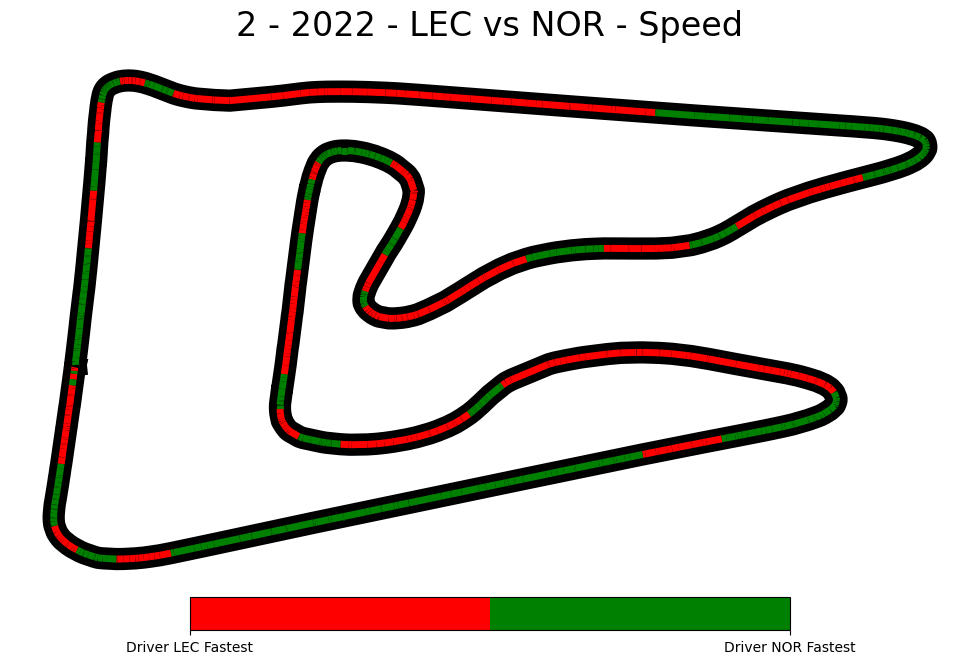

In [6]:
year = 2022
wknd = 1
ses = 'R'
driver1 = 'LEC'
driver2 = 'NOR'
colormap = mpl.cm.plasma

session = ff1.get_session(year, wknd, ses)
weekend = session.event
session.load()


# Get telemetry data for both drivers
lap_driver1 = session.laps.pick_driver(driver1).pick_fastest()
lap_driver2 = session.laps.pick_driver(driver2).pick_fastest()

# Calculate lap times for both drivers
lap = lap_driver1
lap_time_driver1 = lap_driver1.telemetry['Time'].values
lap_time_driver2 = lap_driver2.telemetry['Time'].values

who_fastest = []

# Jump 10 laps at a time and compare lap times
for i in range(0, len(lap_time_driver1) - 10, 10):
    lap_time_1_chunk = lap_time_driver1[i + 10] - lap_time_driver1[i]
    lap_time_2_chunk = lap_time_driver2[i + 10] - lap_time_driver2[i]
    
    if lap_time_1_chunk < lap_time_2_chunk:
        for j in range(10):
            who_fastest.append(True)
    else:
        for j in range(10):
            who_fastest.append(False)

# Check if there are any remaining laps that are not a multiple of 10
remaining_laps = len(lap_time_driver1) % 10
if remaining_laps > 0:
    # Compare the remaining laps individually
    for i in range(len(lap_time_driver1) - remaining_laps, len(lap_time_driver1)):
        if lap_time_driver1[i] < lap_time_driver2[i]:
            who_fastest.append(True)
        else:
            who_fastest.append(False)

# Get telemetry data
x = lap.telemetry['X']              # values for x-axis
y = lap.telemetry['Y']              # values for y-axis

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
fig.suptitle(f'{weekend.name} - {year} - {driver1} vs {driver2} - Speed', size=24, y=0.97)

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')

mask = np.array(who_fastest)  # Repeat each element 10 times for each sector

# After this, we plot the data itself.
# Create background track line
ax.plot(lap.telemetry['X'], lap.telemetry['Y'], color='black', linestyle='-', linewidth=16, zorder=0)
norm = plt.Normalize(0, 1)
# Set the color based on the mask
lc = LineCollection(segments, cmap=mpl.colors.ListedColormap(['red', 'green']), norm=norm, linewidth=5)
lc.set_array(mask)

# Set the values used for colormapping
lc.set_array(mask)

# Merge all line segments together
line = ax.add_collection(lc)


# Finally, we create a color bar as a legend.
# Create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=0, vmax=1)  # Assuming 'who_fastest' contains True and False values
legend_labels = [f"Driver {driver1} Fastest", f"Driver {driver2} Fastest"]
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=mpl.colors.ListedColormap(['red', 'green']),
                                   orientation="horizontal", ticks=[0, 1])
legend.set_ticklabels(legend_labels)

plt.show()

In [8]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.graph_objs as go
import numpy as np
import matplotlib as mpl
from matplotlib.collections import LineCollection

app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div([
    html.H1("F1 Lap Time Comparison Dashboard"),
    html.Label("Select Year:"),
    dcc.Input(id='year-input', type='number', value=2022, min=1950, max=2023),
    html.Label("Select Weekend:"),
    dcc.Input(id='weekend-input', type='number', value=1, min=1, max=100),
    html.Label("Select Driver 1:"),
    dcc.Input(id='driver1-input', type='text', value='LEC'),
    html.Label("Select Driver 2:"),
    dcc.Input(id='driver2-input', type='text', value='NOR'),
    dcc.Graph(id='lap-time-graph')
])

# Define callback to update the graph based on user input
@app.callback(
    Output('lap-time-graph', 'figure'),
    Input('year-input', 'value'),
    Input('weekend-input', 'value'),
    Input('driver1-input', 'value'),
    Input('driver2-input', 'value')
)
def update_graph(year, wek, driver1, driver2):
    ses = 'R'
    session = ff1.get_session(year, wek, ses)
    weekend = session.event
    session.load()
    
    
    # Get telemetry data for both drivers
    lap_driver1 = session.laps.pick_driver(driver1).pick_fastest()
    lap_driver2 = session.laps.pick_driver(driver2).pick_fastest()
    
    # Calculate lap times for both drivers
    lap = lap_driver1
    lap_time_driver1 = lap_driver1.telemetry['Time'].values
    lap_time_driver2 = lap_driver2.telemetry['Time'].values
    
    who_fastest = []
    
    # Jump 10 laps at a time and compare lap times
    for i in range(0, len(lap_time_driver1) - 10, 10):
        lap_time_1_chunk = lap_time_driver1[i + 10] - lap_time_driver1[i]
        lap_time_2_chunk = lap_time_driver2[i + 10] - lap_time_driver2[i]
        
        if lap_time_1_chunk < lap_time_2_chunk:
            for j in range(10):
                who_fastest.append(True)
        else:
            for j in range(10):
                who_fastest.append(False)
    
    # Check if there are any remaining laps that are not a multiple of 10
    remaining_laps = len(lap_time_driver1) % 10
    if remaining_laps > 0:
        # Compare the remaining laps individually
        for i in range(len(lap_time_driver1) - remaining_laps, len(lap_time_driver1)):
            if lap_time_driver1[i] < lap_time_driver2[i]:
                who_fastest.append(True)
            else:
                who_fastest.append(False)
    
    # Get telemetry data
    x = lap.telemetry['X']              # values for x-axis
    y = lap.telemetry['Y']              # values for y-axis
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # We create a plot with title and adjust some setting to make it look good.
    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
    fig.suptitle(f'{weekend.name} - {year} - {driver1} vs {driver2} - Speed', size=24, y=0.97)
    
    # Adjust margins and turn of axis
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
    ax.axis('off')
    
    mask = np.array(who_fastest)  # Repeat each element 10 times for each sector
    
    # After this, we plot the data itself.
    # Create background track line
    ax.plot(lap.telemetry['X'], lap.telemetry['Y'], color='black', linestyle='-', linewidth=16, zorder=0)
    norm = plt.Normalize(0, 1)
    # Set the color based on the mask
    lc = LineCollection(segments, cmap=mpl.colors.ListedColormap(['red', 'green']), norm=norm, linewidth=5)
    lc.set_array(mask)
    
    # Set the values used for colormapping
    lc.set_array(mask)
    
    # Merge all line segments together
    line = ax.add_collection(lc)
    
    
    # Finally, we create a color bar as a legend.
    # Create a color bar as a legend.
    cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
    normlegend = mpl.colors.Normalize(vmin=0, vmax=1)  # Assuming 'who_fastest' contains True and False values
    legend_labels = [f"Driver {driver1} Fastest", f"Driver {driver2} Fastest"]
    legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=mpl.colors.ListedColormap(['red', 'green']),
                                       orientation="horizontal", ticks=[0, 1])
    legend.set_ticklabels(legend_labels)

    return fig


if __name__ == '__main__':
    app.run_server(debug=True)